<a href="https://colab.research.google.com/github/ernesto-miguez/Machine-Learning-training/blob/master/Clustering_Google_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Run cell to load and clean the dataset
%reset -f
import math

from matplotlib import pyplot as plt
import numpy as np
import numpy.linalg as nla
import pandas as pd
import seaborn as sns
import altair as alt
import re
import pdb  # for Python debugger
import sys
from os.path import join




# MANUAL SIMILARITY EXERCISE

## 1. Load data


In [0]:
# Set the output display to have one digit for decimal places and limit it to printing 15 rows
np.set_printoptions(precision=2)
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

choc_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/flavors_of_cacao.csv", sep=",", encoding='latin-1')
choc_data

,Company\n(Maker-if known),Specific Bean Origin\nor Bar Name,REF,Review\nDate,Cocoa\nPercent,Company\nLocation,Rating,Bean\nType,Broad Bean\nOrigin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,NaN,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,NaN,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,NaN,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,NaN,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,NaN,Peru
...,...,...,...,...,...,...,...,...,...
1790,Zotter,Peru,647,2011,70%,Austria,3.75,NaN,Peru
1791,Zotter,Congo,749,2011,65%,Austria,3.00,Forastero,Congo
1792,Zotter,Kerala State,749,2011,65%,Austria,3.50,Forastero,India
1793,Zotter,Kerala State,781,2011,62%,Austria,3.25,NaN,India


## 2. Clean data

In [0]:
# Set the output display to have one digit for decimal places and limit it to printing 15 rows
np.set_printoptions(precision=2)
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

choc_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/flavors_of_cacao.csv", sep=",", encoding='latin-1')
# We can rename the columns 
choc_data.columns = ['maker', 'specific_origin', 'reference_number', 'review_date', 'cocoa_percent', 'maker_location', 'rating', 'bean_type', 'broad_origin']

# Replace empty/null values with "Blend"
choc_data['bean_type'] = choc_data['bean_type'].fillna("Blend")

#@title Cast bean_type to string to remove leading 'u'
choc_data['bean_type'] = choc_data['bean_type'].astype(str)
choc_data['cocoa_percent'] = choc_data['cocoa_percent'].str.strip('%')
choc_data['cocoa_percent'] = pd.to_numeric(choc_data['cocoa_percent'])

#@title Correct spelling mistakes, and replace city with country name
choc_data['maker_location'] = choc_data['maker_location']\
.str.replace('Amsterdam', 'Holland')\
.str.replace('U.K.', 'England')\
.str.replace('Niacragua', 'Nicaragua')\
.str.replace('Domincan Republic', 'Dominican Republic')

# Adding this so that Holland and Netherlands map to the same country
choc_data['maker_location'] = choc_data['maker_location']\
.str.replace('Holland', 'Netherlands')

def cleanup_spelling_abbrev(text):
    replacements = [
        ['-', ', '], ['/ ', ', '], ['/', ', '], ['\(', ', '], [' and', ', '], [' &', ', '], ['\)', ''],
        ['Dom Rep|DR|Domin Rep|Dominican Rep,|Domincan Republic', 'Dominican Republic'],
        ['Mad,|Mad$', 'Madagascar, '],
        ['PNG', 'Papua New Guinea, '],
        ['Guat,|Guat$', 'Guatemala, '],
        ['Ven,|Ven$|Venez,|Venez$', 'Venezuela, '],
        ['Ecu,|Ecu$|Ecuad,|Ecuad$', 'Ecuador, '],
        ['Nic,|Nic$', 'Nicaragua, '],
        ['Cost Rica', 'Costa Rica'],
        ['Mex,|Mex$', 'Mexico, '],
        ['Jam,|Jam$', 'Jamaica, '],
        ['Haw,|Haw$', 'Hawaii, '],
        ['Gre,|Gre$', 'Grenada, '],
        ['Tri,|Tri$', 'Trinidad, '],
        ['C Am', 'Central America'],
        ['S America', 'South America'],
        [', $', ''], [',  ', ', '], [', ,', ', '], ['\xa0', ' '],[',\s+', ','],
        [' Bali', ',Bali']
    ]
    for i, j in replacements:
      text = re.sub(i, j, text)
    return text

choc_data['specific_origin'] = choc_data['specific_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

#@title Cast specific_origin to string
choc_data['specific_origin'] = choc_data['specific_origin'].astype(str)

#@title Replace null-valued fields with the same value as for specific_origin
choc_data['broad_origin'] = choc_data['broad_origin'].fillna(choc_data['specific_origin'])

#@title Clean up spelling mistakes and deal with abbreviations
choc_data['broad_origin'] = choc_data['broad_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

# Change 'Trinitario, Criollo' to 'Criollo, Trinitario'
# Check with choc_data['bean_type'].unique()
choc_data.loc[choc_data['bean_type'].isin(['Trinitario, Criollo']), 'bean_type'] = "Criollo, Trinitario"

# Fix chocolate maker names
choc_data.loc[choc_data['maker']=='Shattel', 'maker'] = 'Shattell'
choc_data['maker'] = choc_data['maker'].str.replace(u'Na\xef\xbf\xbdve','Naive')

# Save the original column names
original_cols = choc_data.columns.values

choc_data.head()

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru


## 3. Preprocess Data


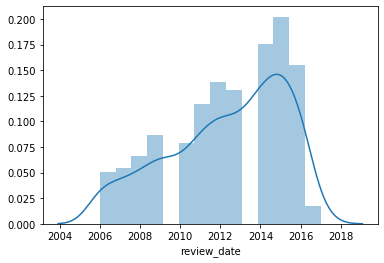

In [0]:
sns.distplot(choc_data['review_date'])

### Normalize rating 

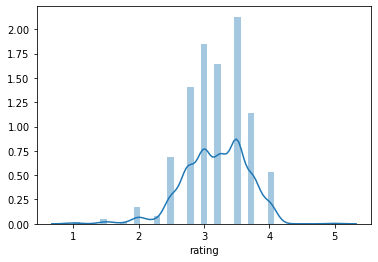

In [0]:
# Check the distribution of rating
sns.distplot(choc_data['rating'])

In [0]:
# It´s a Gaussian, so we use z-score to normalize the data
choc_data['rating_norm'] = (choc_data['rating'] - choc_data['rating'].mean()
                      ) / choc_data['rating'].std()

### Normalize cocoa_percent

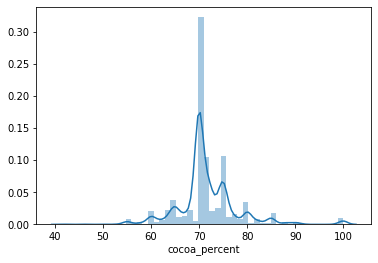

In [0]:
# Examine the distribution of cocoa_percent and consider how to process it
sns.distplot(choc_data['cocoa_percent'])

In [0]:
# The distribution is close enough to a Gaussian so we normalize using z-score
choc_data['cocoa_percent_norm'] = (choc_data['cocoa_percent'] - choc_data['cocoa_percent'].mean()
                             ) / choc_data['cocoa_percent'].std()


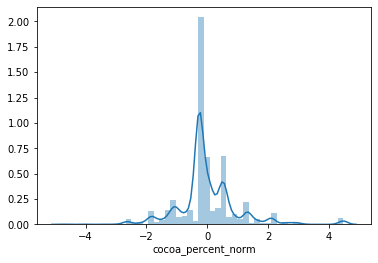

In [0]:
sns.distplot(choc_data['cocoa_percent_norm'])

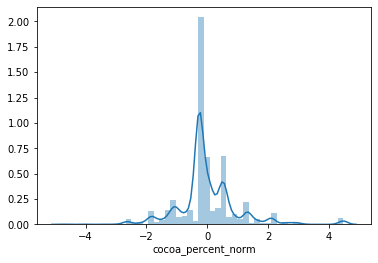

In [0]:
sns.distplot(choc_data['cocoa_percent_norm'])

In [0]:
choc_data.head(
)

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin,rating_norm,cocoa_percent_norm
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome,1.18,-1.38
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo,-0.91,-0.27
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo,-0.39,-0.27
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo,0.66,-0.27
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru,0.66,-0.27


In [0]:
#@title Run code to add latitude and longitude data
# Load lat long data

countries_info = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/countries_lat_long.csv", sep=",", encoding='latin-1')

#Join the chocolate review and geographic information tables on maker country name
choc_data = pd.merge(
    choc_data, countries_info, left_on="maker_location", right_on="name")
choc_data.rename(
    columns={
        "longitude": "maker_long",
        "latitude": "maker_lat"
    }, inplace=True)
choc_data.drop(
    columns=["name", "country"], inplace=True)  # don't need this data

#Join the chocolate review and geographic information tables on origin country name
choc_data = pd.merge(
    choc_data, countries_info, left_on="broad_origin", right_on="name")
choc_data.rename(
    columns={
        "longitude": "origin_long",
        "latitude": "origin_lat"
    },
    inplace=True)
choc_data.drop(
    columns=["name", "country"], inplace=True)  # don't need this data

choc_data.head()

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin,rating_norm,cocoa_percent_norm,maker_lat,maker_long,origin_lat,origin_long
0,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo,-0.91,-0.27,46.23,2.21,8.62,0.82
1,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo,-0.39,-0.27,46.23,2.21,8.62,0.82
2,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo,0.66,-0.27,46.23,2.21,8.62,0.82
3,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru,0.66,-0.27,46.23,2.21,-9.19,-75.02
4,A. Morin,Pablino,1319,2014,70.00,France,4.00,Blend,Peru,1.70,-0.27,46.23,2.21,-9.19,-75.02


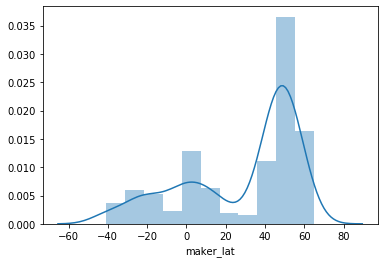

In [0]:
sns.distplot(choc_data['maker_lat'])

In [0]:
# Since lat and lot don´t follow a specific distribution, convert the lat and lon information into quantiles. Display the last few rows to verify the quantile values

numQuantiles = 20
colsQuantiles = ["maker_lat", "maker_long", "origin_lat", "origin_long"]

def createQuantiles(dfColumn, numQuantiles):
  return pd.qcut(dfColumn, numQuantiles, labels=False, duplicates='drop')


for string in colsQuantiles:
  choc_data[string] = createQuantiles(choc_data[string], numQuantiles)

choc_data.tail()

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin,rating_norm,cocoa_percent_norm,maker_lat,maker_long,origin_lat,origin_long
782,Mesocacao,Honduras,1347,2014,70.00,Honduras,3.50,Blend,Honduras,0.66,-0.27,6,0,10,1
783,Malagos,"Davao,Mt Talamo foothills",1121,2013,65.00,Philippines,3.50,Trinitario,Philippines,0.66,-1.06,6,13,10,12
784,Mesocacao,El Salvador,1494,2015,80.00,Honduras,2.75,Blend,El Salvador,-0.91,1.31,6,0,10,0
785,Mesocacao,El Salvador,1494,2015,70.00,Honduras,3.00,Blend,El Salvador,-0.39,-0.27,6,0,10,0
786,Tan Ban Skrati,"Paramaribo,batch 20160043,01",1868,2016,70.00,Suriname,3.25,Trinitario,Suriname,0.13,-0.27,4,4,7,8


In [0]:
def minMaxScaler(numArr):
  minx = np.min(numArr)
  maxx = np.max(numArr)
  numArr = (numArr - minx) / (maxx - minx)
  return numArr

for string in colsQuantiles:
  choc_data[string] = minMaxScaler(choc_data[string])

In [0]:
# duplicate the "maker" feature since it's removed by one-hot encoding function
choc_data['maker2'] = choc_data['maker']
choc_data = pd.get_dummies(choc_data, columns=['maker2'], prefix=['maker'], dtype=float)
# similarly, duplicate the "bean_type" feature
choc_data['bean_type2'] = choc_data['bean_type']
choc_data = pd.get_dummies(choc_data, columns=['bean_type2'], prefix=['bean'], dtype=float)

In [0]:
# Split dataframe into two frames: Original data and data for clustering
choc_data_backup = choc_data.loc[:, original_cols].copy(deep=True)
choc_data.drop(columns=original_cols, inplace=True)

In [0]:
# Inspect the last records to ensure chocolate data is looking good
choc_data.tail()

,rating_norm,cocoa_percent_norm,maker_lat,maker_long,origin_lat,origin_long,maker_A. Morin,maker_AMMA,maker_Adi,maker_Aequare (Gianduja),maker_Ah Cacao,maker_Akesson's (Pralus),maker_Alain Ducasse,maker_Alexandre,maker_Amatller (Simon Coll),maker_Amazona,maker_Ambrosia,maker_Amedei,maker_Ara,maker_Bahen & Co.,maker_Bakau,maker_Belcolade,maker_Belyzium,maker_Benoit Nihant,maker_Beschle (Felchlin),maker_Bonnat,maker_Bouga Cacao (Tulicorp),maker_Bright,maker_Britarev,maker_C-Amaro,maker_Cacao Arabuco,maker_Cacao Barry,maker_Cacao Hunters,maker_Cacao Sampaka,maker_Cacao Store,maker_Cacao de Origen,maker_Cacao de Origin,maker_Cacaosuyo (Theobroma Inversiones),maker_Cacaoyere (Ecuatoriana),maker_Callebaut,...,maker_Tsara (Cinagra),maker_Un Dimanche A Paris,maker_Urzi,maker_Valrhona,maker_Vao Vao (Chocolaterie Robert),maker_Vietcacao (A. Morin),maker_Wellington Chocolate Factory,maker_Whittakers,maker_Wilkie's Organic,maker_Xocolat,maker_Zart Pralinen,maker_Zokoko,maker_Zotter,maker_organicfair,bean_Blend,"bean_Blend-Forastero,Criollo",bean_CCN51,bean_Criollo,bean_Criollo (Amarru),bean_Criollo (Ocumare 61),bean_Criollo (Ocumare 67),bean_Criollo (Ocumare 77),bean_Criollo (Porcelana),bean_Criollo (Wild),"bean_Criollo, Forastero","bean_Criollo, Trinitario",bean_Forastero,bean_Forastero (Amelonado),bean_Forastero (Arriba),bean_Forastero (Arriba) ASS,bean_Forastero (Arriba) ASSS,bean_Forastero (Catongo),bean_Forastero (Nacional),bean_Forastero (Parazinho),bean_Nacional,bean_Nacional (Arriba),bean_Trinitario,bean_Trinitario (85% Criollo),bean_Trinitario (Scavina),"bean_Trinitario, TCGA"
782,0.66,-0.27,0.40,0.00,0.77,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
783,0.66,-1.06,0.40,0.87,0.77,0.92,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
784,-0.91,1.31,0.40,0.00,0.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
785,-0.39,-0.27,0.40,0.00,0.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
786,0.13,-0.27,0.27,0.27,0.54,0.62,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00


## 4. Calculate Manual Similarity

In [0]:
def getSimilarity(obj1, obj2):
  len1 = len(obj1.index)
  len2 = len(obj2.index)
  if not (len1 == len2):
    print ("Error: Compared objects must have same number of features")
    return 0
  else:
    similarity = obj1 - obj2
    similarity = np.sum((similarity**2.0) / 10.0)
    similarity = 1- math.sqrt(similarity)
    return similarity

In [0]:
choc1 = 0  #@param
chocsToCompare = [1, 4]  #@param

print ("Similarity between chocolates " + str(choc1) + " and ...")

for ii in range(chocsToCompare[0], chocsToCompare[1] + 1):
  print (str(ii) + ": " + str(
      getSimilarity(choc_data.loc[choc1], choc_data.loc[ii])))

print ("\n\nFeature data for chocolate " + str(choc1))
print (choc_data_backup.loc[choc1:choc1, :])
print ("\n\nFeature data for compared chocolates " + str(chocsToCompare))
print (choc_data_backup.loc[chocsToCompare[0]:chocsToCompare[1], :])

Similarity between chocolates 0 and ...
1: 0.8346304947537486
2: 0.5038914842612459
3: 0.4555557720237311
4: 0.14327793910573605


Feature data for chocolate 0
      maker specific_origin  reference_number  ...  rating  bean_type broad_origin
0  A. Morin           Kpime              1676  ...    2.75      Blend         Togo

[1 rows x 9 columns]


Feature data for compared chocolates [1, 4]
      maker specific_origin  reference_number  ...  rating  bean_type broad_origin
1  A. Morin          Atsane              1676  ...    3.00      Blend         Togo
2  A. Morin           Akata              1680  ...    3.50      Blend         Togo
3  A. Morin          Quilla              1704  ...    3.50      Blend         Peru
4  A. Morin         Pablino              1319  ...    4.00      Blend         Peru

[4 rows x 9 columns]


## 5. Cluster Chocolate Dataset

In [0]:
#@title Run cell to setup functions
def dfSimilarity(df, centroids):
  ### dfSimilarity = Calculate similarities for dataframe input
  ### We need to calculate ||a-b||^2 = |a|^2 + |b|^2 - 2*|a|*|b|
  ### Implement this with matrix operations
  ### See the Appendix for further explanation
  numPoints = len(df.index)
  numCentroids = len(centroids.index)
  ## Strictly speaking, we don't need to calculate the norm of points
  # because it adds a constant bias to distances
  # But calculating it so that the similarity doesn't go negative
  # And that we expect similarities in [0,1] which aids debugging
  pointNorms = np.square(nla.norm(df, axis=1))
  pointNorms = np.reshape(pointNorms, [numPoints, 1])
  ## Calculate the norm of centroids
  centroidNorms = np.square(nla.norm(centroids, axis=1))
  centroidNorms = np.reshape(centroidNorms, (1, numCentroids))
  ## Calculate |a|^2 + |b|^2 - 2*|a|*|b|
  similarities = pointNorms + centroidNorms - 2.0 * np.dot(
      df, np.transpose(centroids))
  # Divide by the number of features
  # Which is 10 because the one-hot encoding means the "Maker" and "Bean" are
  # weighted twice
  similarities = similarities / 10.0
  # numerical artifacts lead to negligible but negative values that go to NaN on the root
  similarities = similarities.clip(min=0.0)
  # Square root since it's ||a-b||^2
  similarities = np.sqrt(similarities)
  return similarities


def initCentroids(df, k, feature_cols):
  # Pick 'k' examples are random to serve as initial centroids
  limit = len(df.index)
  centroids_key = np.random.randint(0, limit - 1, k)
  centroids = df.loc[centroids_key, feature_cols].copy(deep=True)
  # the indexes get copied over so reset them
  centroids.reset_index(drop=True, inplace=True)
  return centroids


def pt2centroid(df, centroids, feature_cols):
  ### Calculate similarities between all points and centroids
  ### And assign points to the closest centroid + save that distance
  numCentroids = len(centroids.index)
  numExamples = len(df.index)
  # dfSimilarity = Calculate similarities for dataframe input
  dist = dfSimilarity(df.loc[:, feature_cols], centroids.loc[:, feature_cols])
  df.loc[:, 'centroid'] = np.argmin(dist, axis=1)  # closest centroid
  df.loc[:, 'pt2centroid'] = np.min(dist, axis=1)  # minimum distance
  return df


def recomputeCentroids(df, centroids, feature_cols):
  ### For every centroid, recompute it as an average of the points
  ### assigned to it
  numCentroids = len(centroids.index)
  for cen in range(numCentroids):
    dfSubset = df.loc[df['centroid'] == cen,
                      feature_cols]  # all points for centroid
    if not (dfSubset.empty):  # if there are points assigned to the centroid
      clusterAvg = np.sum(dfSubset) / len(dfSubset.index)
      centroids.loc[cen] = clusterAvg
  return centroids


def kmeans(df, k, feature_cols, verbose):
  flagConvergence = False
  maxIter = 100
  iter = 0  # ensure kmeans doesn't run for ever
  centroids = initCentroids(df, k, feature_cols)
  while not (flagConvergence):
    iter += 1
    #Save old mapping of points to centroids
    oldMapping = df['centroid'].copy(deep=True)
    # Perform k-means
    df = pt2centroid(df, centroids, feature_cols)
    centroids = recomputeCentroids(df, centroids, feature_cols)
    # Check convergence by comparing [oldMapping, newMapping]
    newMapping = df['centroid']
    flagConvergence = all(oldMapping == newMapping)
    if verbose == 1:
      print( 'Total distance:' + str(np.sum(df['pt2centroid'])))
    if (iter > maxIter):
      print( 'k-means did not converge! Reached maximum iteration limit of ' \
            + str(maxIter) + '.')
      sys.exit()
      return
  print ('k-means converged for ' + str(k) + ' clusters' + \
        ' after ' + str(iter) + ' iterations!')
  return [df, centroids]



In [0]:
k = 30 #@param

feature_cols = choc_data.columns.values # save original columns
# initialize every point to an impossible value, the k+1 cluster
choc_data['centroid'] = k
# init the point to centroid distance to an impossible value "2" (>1)
choc_data['pt2centroid'] = 2
[choc_data, centroids] = kmeans(choc_data, k, feature_cols, 1)
print("Data for the first few chocolates, with 'centroid' and 'pt2centroid' on the extreme right:")
choc_data.head()

Total distance:424.2537970640995
Total distance:340.529560299762
Total distance:333.65136436083355
Total distance:331.070929096755
Total distance:329.9452447207344
Total distance:328.98846043282725
Total distance:328.51390778569413
Total distance:328.2492615885059
Total distance:327.8770393170285
Total distance:327.3192101243953
k-means converged for 30 clusters after 10 iterations!
Data for the first few chocolates, with 'centroid' and 'pt2centroid' on the extreme right:


,rating_norm,cocoa_percent_norm,maker_lat,maker_long,origin_lat,origin_long,maker_A. Morin,maker_AMMA,maker_Adi,maker_Aequare (Gianduja),maker_Ah Cacao,maker_Akesson's (Pralus),maker_Alain Ducasse,maker_Alexandre,maker_Amatller (Simon Coll),maker_Amazona,maker_Ambrosia,maker_Amedei,maker_Ara,maker_Bahen & Co.,maker_Bakau,maker_Belcolade,maker_Belyzium,maker_Benoit Nihant,maker_Beschle (Felchlin),maker_Bonnat,maker_Bouga Cacao (Tulicorp),maker_Bright,maker_Britarev,maker_C-Amaro,maker_Cacao Arabuco,maker_Cacao Barry,maker_Cacao Hunters,maker_Cacao Sampaka,maker_Cacao Store,maker_Cacao de Origen,maker_Cacao de Origin,maker_Cacaosuyo (Theobroma Inversiones),maker_Cacaoyere (Ecuatoriana),maker_Callebaut,...,maker_Urzi,maker_Valrhona,maker_Vao Vao (Chocolaterie Robert),maker_Vietcacao (A. Morin),maker_Wellington Chocolate Factory,maker_Whittakers,maker_Wilkie's Organic,maker_Xocolat,maker_Zart Pralinen,maker_Zokoko,maker_Zotter,maker_organicfair,bean_Blend,"bean_Blend-Forastero,Criollo",bean_CCN51,bean_Criollo,bean_Criollo (Amarru),bean_Criollo (Ocumare 61),bean_Criollo (Ocumare 67),bean_Criollo (Ocumare 77),bean_Criollo (Porcelana),bean_Criollo (Wild),"bean_Criollo, Forastero","bean_Criollo, Trinitario",bean_Forastero,bean_Forastero (Amelonado),bean_Forastero (Arriba),bean_Forastero (Arriba) ASS,bean_Forastero (Arriba) ASSS,bean_Forastero (Catongo),bean_Forastero (Nacional),bean_Forastero (Parazinho),bean_Nacional,bean_Nacional (Arriba),bean_Trinitario,bean_Trinitario (85% Criollo),bean_Trinitario (Scavina),"bean_Trinitario, TCGA",centroid,pt2centroid
0,-0.91,-0.27,0.60,0.40,0.62,0.77,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12,0.35
1,-0.39,-0.27,0.60,0.40,0.62,0.77,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,27,0.36
2,0.66,-0.27,0.60,0.40,0.62,0.77,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,14,0.21
3,0.66,-0.27,0.60,0.40,0.15,0.23,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,14,0.20
4,1.70,-0.27,0.60,0.40,0.15,0.23,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,14,0.37


In [0]:
clusterNumber = 7 #@param
choc_data_backup.loc[choc_data['centroid'] == clusterNumber, :]

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
91,Michel Cluizel,"Carenero Superior,Concepcion",117,2007,66.00,France,3.50,Trinitario,Venezuela
146,Domori,Granella,135,2007,60.00,Italy,3.25,Trinitario,Venezuela
152,Urzi,"Sur del Lago,Merida",1327,2014,65.00,Italy,3.25,Trinitario,Venezuela
231,Valrhona,"Sambirano,Ampamakia 2005,Millot P",75,2006,64.00,France,3.50,Trinitario,Madagascar
233,Beschle (Felchlin),Madagascar,636,2011,64.00,Switzerland,3.00,Trinitario,Madagascar
...,...,...,...,...,...,...,...,...,...
683,Cravve,Vanuatu,975,2012,64.00,Australia,3.25,Trinitario,Vanuatu
687,Adi,Vanua Levu,705,2011,60.00,Fiji,2.75,Trinitario,Fiji
692,Cravve,"Namau Village,N Taileva P,batch a2812",975,2012,67.00,Australia,3.25,Trinitario,Fiji
725,Ambrosia,Belize,1494,2015,64.00,Canada,3.00,Trinitario,Belize


## 6. Quality Metrics for Clusters


In [0]:
#@title Run cell to set up functions { display-mode: "form" }
def clusterCardinality(df):
  k = np.max(df['centroid']) + 1
  k = np.float64(k)
  k = k.astype(int)
  print( 'Number of clusters:' + str(k))
  clCard = np.zeros(k)
  for kk in range(k):
    clCard[kk] = np.sum(df['centroid'] == kk)
  clCard = clCard.astype(int)
  # print "Cluster Cardinality:"+str(clCard)
  plt.figure()
  plt.bar(range(k), clCard)
  plt.title('Cluster Cardinality')
  plt.xlabel('Cluster Number: ' + str(0) + ' to ' + str(k - 1))
  plt.ylabel('Points in Cluster')
  return clCard


def clusterMagnitude(df):
  k = np.max(df['centroid']) + 1
  k = np.float64(k)
  k = k.astype(int)
  cl = np.zeros(k)
  clMag = np.zeros(k)
  for kk in range(k):
    idx = np.where(df['centroid'] == kk)
    idx = idx[0]
    clMag[kk] = np.sum(df.loc[idx, 'pt2centroid'])
  # print "Cluster Magnitude:",clMag #precision set using np pref
  plt.figure()
  plt.bar(range(k), clMag)
  plt.title('Cluster Magnitude')
  plt.xlabel('Cluster Number: ' + str(0) + ' to ' + str(k - 1))
  plt.ylabel('Total Point-to-Centroid Distance')
  return clMag


def plotCardVsMag(clCard, clMag):
  plt.figure()
  plt.scatter(clCard, clMag)
  plt.xlim(xmin=0)
  plt.ylim(ymin=0)
  plt.title('Magnitude vs Cardinality')
  plt.ylabel('Magnitude')
  plt.xlabel('Cardinality')


def clusterQualityMetrics(df):
  clCard = clusterCardinality(df)
  clMag = clusterMagnitude(df)
  plotCardVsMag(clCard, clMag)

Number of clusters:30


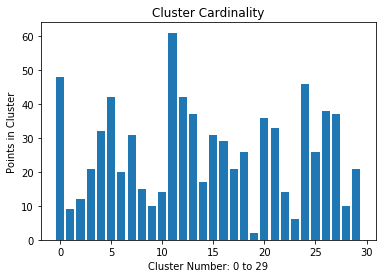

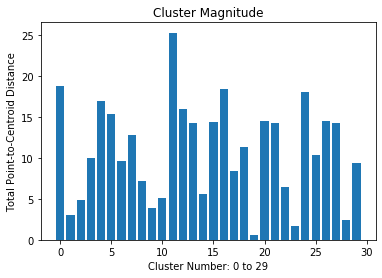

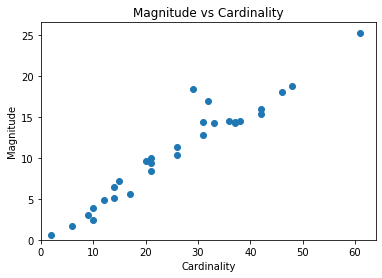

In [0]:
clusterQualityMetrics(choc_data)

## Find Optimum Number of Clusters 

k-means converged for 5 clusters after 13 iterations!
k-means converged for 7 clusters after 10 iterations!
k-means converged for 9 clusters after 23 iterations!
k-means converged for 11 clusters after 6 iterations!
k-means converged for 13 clusters after 26 iterations!
k-means converged for 15 clusters after 12 iterations!
k-means converged for 17 clusters after 16 iterations!
k-means converged for 19 clusters after 16 iterations!
k-means converged for 21 clusters after 21 iterations!
k-means converged for 23 clusters after 16 iterations!
k-means converged for 25 clusters after 17 iterations!
k-means converged for 27 clusters after 13 iterations!
k-means converged for 29 clusters after 17 iterations!
k-means converged for 31 clusters after 14 iterations!
k-means converged for 33 clusters after 16 iterations!
k-means converged for 35 clusters after 12 iterations!
k-means converged for 37 clusters after 25 iterations!
k-means converged for 39 clusters after 12 iterations!
k-means conver

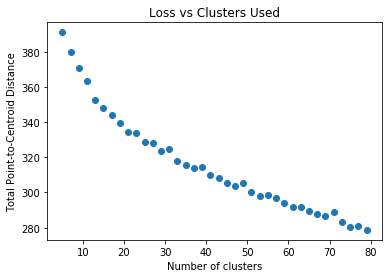

In [0]:
# Plot loss vs number of clusters
def lossVsClusters(kmin, kmax, kstep, choc_data):
  kmax +=1
  kRange = range(kmin, kmax, kstep)
  loss = np.zeros(len(kRange))
  lossCtr = 0
  for kk in kRange:
    [choc_data, centroids] = kmeans(choc_data, kk, feature_cols, 0)
    loss[lossCtr] = np.sum(choc_data['pt2centroid'])
    lossCtr +=1
  plt.scatter(kRange, loss)
  plt.title('Loss vs Clusters Used')
  plt.xlabel('Number of clusters')
  plt.ylabel('Total Point-to-Centroid Distance')


kmin = 5  # @param
kmax = 80  # @param
kstep = 2  # @param
lossVsClusters(kmin, kmax, kstep, choc_data)

## Appendix: Calculating Point to Centroid Distance for Large Datasets

In [0]:
# Calculate distances between "A" point and "B" centroids to return axb array where a_i, b_j distance is at (i,j) position
A = np.array([[1, 2, 3],\
              [3, 1, 2],\
              [0, 0, 0]])
A = A / np.max(A)
B = np.array([[4, 5, 6],\
             [6, 6, 6]])
B = B / np.max(B)
numPoints = A.shape[0]
numCentroids = B.shape[0]
pointNorms = np.reshape(nla.norm(A, axis=1)** 2.0, [numPoints, 1])
centroidNorms = np.reshape(nla.norm(B, axis=1)** 2.0, (1, numCentroids))
print("Distance matrix of size 'p' by 'c' where Distance between point 'p' and centroid 'c' is at (p,c)")
print(pointNorms + centroidNorms - 2.0 * np.dot(A, np.transpose(B)))


Distance matrix of size 'p' by 'c' where Distance between point 'p' and centroid 'c' is at (p,c)
[[0.14 0.56]
 [0.47 0.56]
 [2.14 3.  ]]


# SUPERVISED SIMILARITY MEASURE EXERCISE

## 1. Load and clean data

In [0]:
#@title Run to load and clean the dataset
%reset -f
from __future__ import print_function

import math
import numpy as np
import numpy.linalg as nla
import pandas as pd
import re
from os.path import join
from matplotlib import pyplot as plt

%tensorflow_version 1.x
import tensorflow as tf

In [0]:
# Set the output display to have one digit for decimal places and limit it to
# printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

choc_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/flavors_of_cacao.csv", sep=",", encoding='latin-1')

# We can rename the columns.
choc_data.columns = ['maker', 'specific_origin', 'reference_number', 'review_date', 'cocoa_percent', 'maker_location', 'rating', 'bean_type', 'broad_origin']

# choc_data.dtypes

# Replace empty/null values with "Blend"
choc_data['bean_type'] = choc_data['bean_type'].fillna('Blend')

#@title Cast bean_type to string to remove leading 'u'
choc_data['bean_type'] = choc_data['bean_type'].astype(str)
choc_data['cocoa_percent'] = choc_data['cocoa_percent'].str.strip('%')
choc_data['cocoa_percent'] = pd.to_numeric(choc_data['cocoa_percent'])

#@title Correct spelling mistakes, and replace city with country name
choc_data['maker_location'] = choc_data['maker_location']\
.str.replace('Amsterdam', 'Holland')\
.str.replace('U.K.', 'England')\
.str.replace('Niacragua', 'Nicaragua')\
.str.replace('Domincan Republic', 'Dominican Republic')

# Adding this so that Holland and Netherlands map to the same country.
choc_data['maker_location'] = choc_data['maker_location']\
.str.replace('Holland', 'Netherlands')

def cleanup_spelling_abbrev(text):
    replacements = [
        ['-', ', '], ['/ ', ', '], ['/', ', '], ['\(', ', '], [' and', ', '], [' &', ', '], ['\)', ''],
        ['Dom Rep|DR|Domin Rep|Dominican Rep,|Domincan Republic', 'Dominican Republic'],
        ['Mad,|Mad$', 'Madagascar, '],
        ['PNG', 'Papua New Guinea, '],
        ['Guat,|Guat$', 'Guatemala, '],
        ['Ven,|Ven$|Venez,|Venez$', 'Venezuela, '],
        ['Ecu,|Ecu$|Ecuad,|Ecuad$', 'Ecuador, '],
        ['Nic,|Nic$', 'Nicaragua, '],
        ['Cost Rica', 'Costa Rica'],
        ['Mex,|Mex$', 'Mexico, '],
        ['Jam,|Jam$', 'Jamaica, '],
        ['Haw,|Haw$', 'Hawaii, '],
        ['Gre,|Gre$', 'Grenada, '],
        ['Tri,|Tri$', 'Trinidad, '],
        ['C Am', 'Central America'],
        ['S America', 'South America'],
        [', $', ''], [',  ', ', '], [', ,', ', '], ['\xa0', ' '],[',\s+', ','],
        [' Bali', ',Bali']
    ]
    for i, j in replacements:
        text = re.sub(i, j, text)
    return text

choc_data['specific_origin'] = choc_data['specific_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

#@title Cast specific_origin to string
choc_data['specific_origin'] = choc_data['specific_origin'].astype(str)

#@title Replace null-valued fields with the same value as for specific_origin
choc_data['broad_origin'] = choc_data['broad_origin'].fillna(choc_data['specific_origin'])

#@title Clean up spelling mistakes and deal with abbreviations
choc_data['broad_origin'] = choc_data['broad_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

# Change 'Trinitario, Criollo' to "Criollo, Trinitario"
# Check with choc_data['bean_type'].unique()
choc_data.loc[choc_data['bean_type'].isin(['Trinitario, Criollo']),'bean_type'] = "Criollo, Trinitario"
# Confirm with choc_data[choc_data['bean_type'].isin(['Trinitario, Criollo'])]

# Fix chocolate maker names
choc_data.loc[choc_data['maker']=='Shattel','maker'] = 'Shattell'
choc_data['maker'] = choc_data['maker'].str.replace(u'Na\xef\xbf\xbdve','Naive')

choc_data.head()

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru


## 2. Process Data

In [0]:
choc_data.drop(columns=['review_date','reference_number'],inplace=True)
choc_data.head()

,maker,specific_origin,cocoa_percent,maker_location,rating,bean_type,broad_origin
0,A. Morin,Agua Grande,63.00,France,3.75,Blend,Sao Tome
1,A. Morin,Kpime,70.00,France,2.75,Blend,Togo
2,A. Morin,Atsane,70.00,France,3.00,Blend,Togo
3,A. Morin,Akata,70.00,France,3.50,Blend,Togo
4,A. Morin,Quilla,70.00,France,3.50,Blend,Peru


## 3. Generate Embeddings from DNN

In [0]:
#@title Functions to Build and Train a Similarity DNN Model

class SimilarityModel(object):
  """Class to build, train, and inspect a Similarity Model.

  This class builds a deep neural network that maps a dataset of entities
  with heterogenous features to an embedding space.
  Given a dataset as a pandas dataframe, determine the model by specifying
  the set of features used as input and as labels to the DNN, and the
  size of each hidden layer. The data is mapped to the embedding space
  in the last hidden layer.
  
  To build an auto-encoder, make the set of output features identical to the set
  of input features. Alternatively, build a predictor by using a single feature
  as the label. When using a single feature as a label, ensure
  this feature is removed from the input, or add at least
  one hidden layer of a sufficiently low dimension such that the model cannot
  trivially learn the label.
  Caveat: The total loss being minimized is a simple sum of losses for each
    output label (plus the regularization). If the output feature set combines
    sparse and dense features, the total loss is a sum of cross-entropy soft-max
    losses with root mean squared error losses, potentially in different scales,
    which could emphasis some output labels more than others.
  """

  def __init__(self,
               dataframe,
               input_feature_names,
               output_feature_names,
               dense_feature_names,
               sparse_input_feature_embedding_dims,
               hidden_dims=[32],
               l2_regularization=0.0,
               use_bias=True,
               batch_size=100,
               inspect=False):
    """Build a similarity model.

    Args:
      dataframe: the pandas dataframe used to train and validate the model.
      input_feature_names: list of strings, names of input feature columns.
      output_feature_names: list of strings, names of output feature columns.
      dense_feature_names: list of strings, names of feature columns that are
        treated as dense. All other feature columns are treated as sparse.
      sparse_input_feature_embedding_dims: dictionary that maps feature names to
        ints, expressing the embedding dimension of each input feature. Any
        sparse feature in input_feature_names must be in this dictionary.
      hidden_dims: list of ints, dimensions of each hidden layer. These hidden
        layers are not counting the first layer which is a concatenation of the
        input embeddings and the dense input features. Hence, this list can be
        empty, in which case the outputs of the network are directly connected
        to the input embeddings and/or dense inputs.
      use_bias: bool, if true, add a bias term to each hidden layer.
      batch_size: int, batch size.
      inspect: bool, if true, add each tensor of the model to the list of
        tensors that are inspected.
    """
    used_feature_names = tuple(
        set(input_feature_names).union(output_feature_names))
    sparse_feature_names = tuple(
        set(used_feature_names).difference(dense_feature_names))
    # Dictionary mapping each sparse feature column to its vocabulary.
    ### sparse_feature_vocabs = { 'maker': [u'A. Morin', u'AMMA', ...], ... }
    sparse_feature_vocabs = {
        sfn: sorted(list(set(choc_data[sfn].values)))
        for sfn in sparse_feature_names
    }

    # Sparse output features are mapped to ids via tf.feature_to_id, hence
    # we need key-id pairs for these vocabularies.
    sparse_output_feature_names = (
        tuple(set(sparse_feature_names).intersection(output_feature_names)))
    keys_and_values = {}
    for fn in sparse_output_feature_names:
      keys = tf.constant(
          sparse_feature_vocabs[fn],
          dtype=tf.string,
          name='{}_vocab_keys'.format(fn))
      values = tf.range(
          len(sparse_feature_vocabs[fn]),
          dtype=tf.int64,
          name='{}_vocab_values'.format(fn))
      keys_and_values[fn] = (keys, values)

    # Class instance data members.
    self._session = None
    self._loss = None
    self._metrics = {}
    self._embeddings = None
    self._vars_to_inspect = {}

    def split_dataframe(df, holdout_fraction=0.1):
      """Splits a pandas dataframe into training and test sets.

      Args:
        df: the source pandas dataframe.
        holdout_fraction: fraction of dataframe rows to use in the test set.

      Returns:
        A pair of non-overlapping pandas dataframe for training and holdout.
      """
      test = df.sample(frac=holdout_fraction, replace=False)
      train = df[~df.index.isin(test.index)]
      return train, test

    train_dataframe, test_dataframe = split_dataframe(dataframe)

    def make_batch(dataframe, batch_size):
      """Creates a batch of examples.

      Args:
        dataframe: a panda dataframe with rows being examples and with
          columns being feature columns.
        batch_size: the batch size.

      Returns:
        A dictionary of tensors, keyed by their feature names.
        Each tensor is of shape [batch_size]. Tensors for sparse features are of
        strings, while tensors for dense features are of floats.
      """
      used_features = {ufn: dataframe[ufn] for ufn in used_feature_names}
      batch = (
          tf.data.Dataset.from_tensor_slices(used_features).shuffle(1000)
          .repeat().batch(batch_size).make_one_shot_iterator().get_next())
      if inspect:
        for k, v in batch.items():
          self._vars_to_inspect['input_%s' % k] = v
      return batch

    def generate_feature_columns(feature_names):
      """Creates the list of used feature columns.

      Args:
        feature_names: an iterable of strings with the names of the features for
          which feature columns are generated.

      Returns:
        A dictionary, keyed by feature names, of _DenseColumn and
        _NumericColumn.
      """
      used_sparse_feature_names = (
          tuple(set(sparse_feature_names).intersection(feature_names)))
      used_dense_feature_names = (
          tuple(set(dense_feature_names).intersection(feature_names)))
      f_columns = {}
      for sfn in used_sparse_feature_names:
        sf_column = tf.feature_column.categorical_column_with_vocabulary_list(
            key=sfn,
            vocabulary_list=sparse_feature_vocabs[sfn],
            num_oov_buckets=0)
        f_columns[sfn] = tf.feature_column.embedding_column(
            categorical_column=sf_column,
            dimension=sparse_input_feature_embedding_dims[sfn],
            combiner='mean',
            initializer=tf.truncated_normal_initializer(stddev=.1))
      for dfn in used_dense_feature_names:
        f_columns[dfn] = tf.feature_column.numeric_column(dfn)
      return f_columns

    def create_tower(features, columns):
      """Creates the tower mapping features to embeddings.

      Args:
        features: a dictionary of tensors of shape [batch_size], keyed by
          feature name. Sparse features are associated to tensors of strings,
          while dense features are associated to tensors of floats.
        columns: a dictionary, keyed by feature names, of _DenseColumn and
          _NumericColumn.

      Returns:
        A pair of elements: hidden_layer and output_layer.
          hidden_layer is a tensor of shape [batch_size, hidden_dims[-1]].
          output_layer is a dictionary keyed by the output feature names, of
            dictionaries {'labels': labels, 'logits': logits}.
            Dense output features have both labels and logits as float tensors 
            of shape [batch_size, 1]. Sparse output features have labels as
            string tensors of shape [batch_size, 1] and logits as float tensors
            of shape [batch_size, len(sparse_feature_vocab)].
      """
      # TODO: sanity check the arguments.
      # Input features.
      input_columns = [columns[fn] for fn in input_feature_names]
      hidden_layer = tf.feature_column.input_layer(features, input_columns)
      dense_input_feature_names = (
          tuple(set(dense_feature_names).intersection(input_feature_names)))
      input_dim = (
          sum(sparse_input_feature_embedding_dims.values()) +
          len(dense_input_feature_names))
      for layer_idx, layer_output_dim in enumerate(hidden_dims):
        w = tf.get_variable(
            'hidden%d_w_' % layer_idx,
            shape=[input_dim, layer_output_dim],
            initializer=tf.truncated_normal_initializer(
                stddev=1.0 / np.sqrt(layer_output_dim)))
        if inspect:
          self._vars_to_inspect['hidden%d_w_' % layer_idx] = w
        hidden_layer = tf.matmul(hidden_layer, w)  # / 10.)
        if inspect:
          self._vars_to_inspect['hidden_layer_%d' % layer_idx] = hidden_layer
        input_dim = layer_output_dim
      # Output features.
      output_layer = {}
      for ofn in output_feature_names:
        if ofn in sparse_feature_names:
          feature_dim = len(sparse_feature_vocabs[ofn])
        else:
          feature_dim = 1
        w = tf.get_variable(
            'output_w_%s' % ofn,
            shape=[input_dim, feature_dim],
            initializer=tf.truncated_normal_initializer(stddev=1.0 /
                                                        np.sqrt(feature_dim)))
        if inspect:
          self._vars_to_inspect['output_w_%s' % ofn] = w
        if use_bias:
          bias = tf.get_variable(
              'output_bias_%s' % ofn,
              shape=[1, feature_dim],
              initializer=tf.truncated_normal_initializer(stddev=1.0 /
                                                          np.sqrt(feature_dim)))
          if inspect:
            self._vars_to_inspect['output_bias_%s' % ofn] = bias
        else:
          bias = tf.constant(0.0, shape=[1, feature_dim])
        output_layer[ofn] = {
            'labels':
                features[ofn],
            'logits':
                tf.add(tf.matmul(hidden_layer, w), bias)  # w / 10.), bias)
        }
        if inspect:
          self._vars_to_inspect['output_labels_%s' %
                                ofn] = output_layer[ofn]['labels']
          self._vars_to_inspect['output_logits_%s' %
                                ofn] = output_layer[ofn]['logits']
      return hidden_layer, output_layer

    def similarity_loss(top_embeddings, output_layer):
      """Build the loss to be optimized.

      Args:
        top_embeddings: First element returned by create_tower.
        output_layer: Second element returned by create_tower.

      Returns:
        total_loss: A tensor of shape [1] with the total loss to be optimized.
        losses: A dictionary keyed by output feature names, of tensors of shape
          [1] with the contribution to the loss of each output feature.
      """
      losses = {}
      total_loss = tf.scalar_mul(l2_regularization,
                                 tf.nn.l2_loss(top_embeddings))
      for fn, output in output_layer.items():
        if fn in sparse_feature_names:
          losses[fn] = tf.reduce_mean(
              tf.nn.sparse_softmax_cross_entropy_with_logits(
                  logits=output['logits'],
                  labels=tf.feature_to_id(
                      output['labels'], keys_and_values=keys_and_values[fn])))
        else:
          losses[fn] = tf.sqrt(
              tf.reduce_mean(
                  tf.square(output['logits'] -
                            tf.cast(output['labels'], tf.float32))))
        total_loss += losses[fn]
      return total_loss, losses

    # Body of the constructor.
    input_feature_columns = generate_feature_columns(input_feature_names)
    # Train
    with tf.variable_scope('model', reuse=False):
      train_hidden_layer, train_output_layer = create_tower(
          make_batch(train_dataframe, batch_size), input_feature_columns)
      self._train_loss, train_losses = similarity_loss(train_hidden_layer,
                                                       train_output_layer)
    # Test
    with tf.variable_scope('model', reuse=True):
      test_hidden_layer, test_output_layer = create_tower(
          make_batch(test_dataframe, batch_size), input_feature_columns)
      test_loss, test_losses = similarity_loss(test_hidden_layer,
                                               test_output_layer)
    # Whole dataframe to get final embeddings
    with tf.variable_scope('model', reuse=True):
      self._hidden_layer, _ = create_tower(
          make_batch(dataframe, dataframe.shape[0]), input_feature_columns)
    # Metrics is a dictionary of dictionaries of dictionaries.
    # The 3 levels are used as plots, line colors, and line styles respectively.
    self._metrics = {
        'total': {
            'train': {'loss': self._train_loss},
            'test': {'loss': test_loss}
        },
        'feature': {
            'train': {'%s loss' % k: v for k, v in train_losses.items()},
            'test': {'%s loss' % k: v for k, v in test_losses.items()}
        }
    }

  def train(self,
            num_iterations=30,
            learning_rate=1.0,
            plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.

    Args:
      num_iterations: int, the number of iterations to run.
      learning_rate: float, the optimizer learning rate.
      plot_results: bool, whether to plot the results at the end of training.
      optimizer: tf.train.Optimizer, the optimizer to be used for training.
    """
    with self._train_loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._train_loss)
      opt_init_op = tf.variables_initializer(opt.variables())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.local_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      self._session.run(opt_init_op)
      if plot_results:  
        iterations = []
        metrics_vals = {k0: {k1: {k2: []
                                  for k2 in v1}
                             for k1, v1 in v0.items()}
                        for k0, v0 in self._metrics.items()}

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, self._metrics))

        # Printing the 1 liner with losses.
        if (i % 10 == 0) or i == num_iterations:
          print('\riteration%6d,   ' % i + ',   '.join(
              ['%s %s %s: %7.3f' % (k0, k1, k2, v2)
               for k0, v0 in results.items()
               for k1, v1 in v0.items()
               for k2, v2 in v1.items()])
                , end=" "
               )
          if plot_results:
            iterations.append(i)
            for k0, v0 in results.items():
              for k1, v1 in v0.items():
                for k2, v2 in v1.items():
                  metrics_vals[k0][k1][k2].append(results[k0][k1][k2])

      # Feedforward the entire dataframe to get all the embeddings.
      self._embeddings = self._session.run(self._hidden_layer)

      # Plot the losses and embeddings.
      if plot_results:
        num_subplots = len(metrics_vals) + 1
        colors = 10 * ('red', 'blue', 'black', 'green')
        styles = 10 * ('-', '--', '-.', ':')
        # Plot the metrics.
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i0, (k0, v0) in enumerate(metrics_vals.items()):
          ax = fig.add_subplot(1, num_subplots, i0+1)
          ax.set_title(k0)
          for i1, (k1, v1) in enumerate(v0.items()):
            for i2, (k2, v2) in enumerate(v1.items()):
              ax.plot(iterations, v2, label='%s %s' % (k1, k2),
                      color=colors[i1], linestyle=styles[i2])
          ax.set_xlim([1, num_iterations])
          ax.set_yscale('log')
          ax.legend()
        # Plot the embeddings (first 3 dimensions).
        ax.legend(loc='upper right')
        ax = fig.add_subplot(1, num_subplots, num_subplots)
        ax.scatter(
            self._embeddings[:, 0], self._embeddings[:, 1],
            alpha=0.5, marker='o')
        ax.set_title('embeddings')


  @property
  def embeddings(self):
    return self._embeddings

------ build model
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for

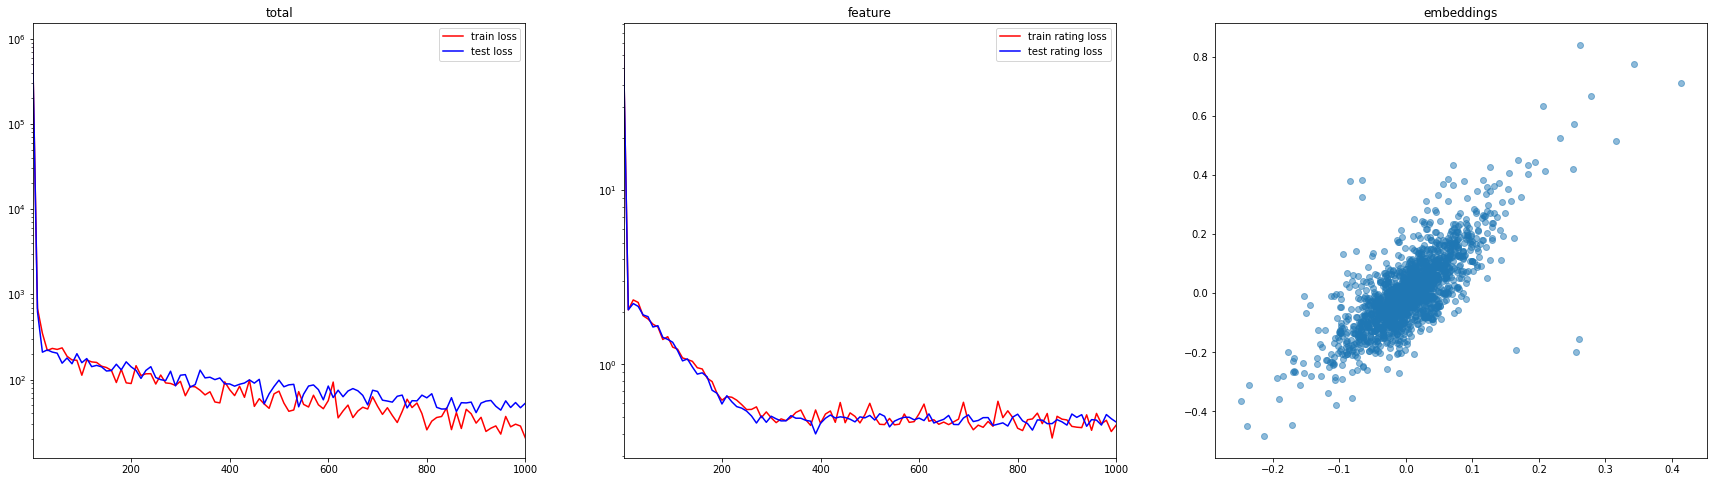

In [0]:
#@title Training a DNN Similarity Model

# Define some constants related to this dataset.
sparse_feature_names = ('maker', 'maker_location', 'broad_origin',
                        'specific_origin', 'bean_type')
dense_feature_names = ('reference_number', 'review_date', 'cocoa_percent',
                       'rating')

# Set of features used as input to the similarity model.
input_feature_names = ('maker', 'maker_location', 'broad_origin',
                       'cocoa_percent', 'bean_type','rating', )
# Set of features used as output to the similarity model.
output_feature_names = ['rating']  #@param

# As a rule of thumb, a reasonable choice for the embedding dimension of a
# sparse feature column is the log2 of the cardinality of its vocabulary.
# sparse_input_feature_embedding_dims = { 'maker': 9, 'maker_location': 6, ... }
default_embedding_dims = {
    sfn: int(round(math.log(choc_data[sfn].nunique()) / math.log(2)))
    for sfn in set(sparse_feature_names).intersection(input_feature_names)
}
# Dictionary mapping each sparse input feature to the dimension of its embedding
# space.
sparse_input_feature_embedding_dims = default_embedding_dims  # can be a param

# Weight of the L2 regularization applied to the top embedding layer.
l2_regularization = 10  #@param
# List of dimensions of the hidden layers of the deep neural network.
hidden_dims = [20, 10]  #@param

print('------ build model')
with tf.Graph().as_default():
  similarity_model = SimilarityModel(
      choc_data,
      input_feature_names=input_feature_names,
      output_feature_names=output_feature_names,
      dense_feature_names=dense_feature_names,
      sparse_input_feature_embedding_dims=sparse_input_feature_embedding_dims,
      hidden_dims=hidden_dims,
      l2_regularization=l2_regularization,
      batch_size=100,
      use_bias=True,
      inspect=True)

print('------ train model')
similarity_model.train(
    num_iterations=1000,
    learning_rate=0.1,
    optimizer=tf.train.AdagradOptimizer)
print('\n')

## 4. Cluster Chocolate Dataset

In [0]:
#@title Run cell to set up functions
def dfSimilarity(df,centroids):
  ### dfSimilarity = Calculate similarities for dataframe input
  ### We need to calculate ||a-b||^2 = |a|^2 + |b|^2 - 2*|a|*|b|
  ### Implement this with matrix operations
  ### See the Appendix for further explanation
  numPoints = len(df.index)
  numCentroids = len(centroids.index)
  ## Strictly speaking, we don't need to calculate the norm of points
  # because it adds a constant bias to distances
  # But calculating it so that the similarity doesn't go negative
  # And that we expect similarities in [0,1] which aids debugging
  pointNorms = np.square(nla.norm(df,axis=1))
  pointNorms = np.reshape(pointNorms,[numPoints,1])
  ## Calculate the norm of centroids
  centroidNorms = np.square(nla.norm(centroids,axis=1))
  centroidNorms = np.reshape(centroidNorms,(1,numCentroids))
  ## Calculate |a|^2 + |b|^2 - 2*|a|*|b|
  similarities = pointNorms + centroidNorms - 2.0*np.dot(df,np.transpose(centroids))
  # Divide by the number of features
  # Which is 10 because the one-hot encoding means the "Maker" and "Bean" are
  # weighted twice
  similarities = similarities/10.0
  # numerical artifacts lead to negligible but negative values that go to NaN on the root
  similarities = similarities.clip(min=0.0)
  # Square root since it's ||a-b||^2
  similarities = np.sqrt(similarities)
  return similarities

def initCentroids(df,k,feature_cols):
  # Pick 'k' examples are random to serve as initial centroids
  limit = len(df.index)
  centroids_key = np.random.randint(0,limit-1,k)
  centroids = df.loc[centroids_key,feature_cols].copy(deep=True)
  # the indexes get copied over so reset them
  centroids.reset_index(drop=True,inplace=True)
  return centroids

def pt2centroid(df,centroids,feature_cols):
  ### Calculate similarities between all points and centroids
  ### And assign points to the closest centroid + save that distance
  numCentroids = len(centroids.index)
  numExamples = len(df.index)
  # dfSimilarity = Calculate similarities for dataframe input
  dist = dfSimilarity(df.loc[:,feature_cols],centroids.loc[:,feature_cols])
  df.loc[:,'centroid'] = np.argmin(dist,axis=1) # closest centroid
  df.loc[:,'pt2centroid'] = np.min(dist,axis=1) # minimum distance
  return df

def recomputeCentroids(df,centroids,feature_cols):
  ### For every centroid, recompute it as an average of the points
  ### assigned to it
  numCentroids = len(centroids.index)
  for cen in range(numCentroids):
    dfSubset = df.loc[df['centroid'] == cen, feature_cols] # all points for centroid
    if not(dfSubset.empty): # if there are points assigned to the centroid
      clusterAvg = np.sum(dfSubset)/len(dfSubset.index)
      centroids.loc[cen] = clusterAvg
  return centroids

def kmeans(df,k,feature_cols,verbose):
  flagConvergence = False
  maxIter = 100
  iter = 0                      # ensure kmeans doesn't run for ever
  centroids = initCentroids(df,k,feature_cols)
  while not(flagConvergence):
    iter += 1
    #Save old mapping of points to centroids
    oldMapping = df['centroid'].copy(deep=True)
    # Perform k-means
    df = pt2centroid(df,centroids,feature_cols)
    centroids = recomputeCentroids(df,centroids,feature_cols)
    # Check convergence by comparing [oldMapping, newMapping]
    newMapping = df['centroid']
    flagConvergence = all(oldMapping == newMapping)
    if verbose == 1:
      print("Total distance:" + str(np.sum(df['pt2centroid'])))
    if (iter > maxIter):
      print('k-means did not converge! Reached maximum iteration limit of ' \
            + str(maxIter) + '.')
      sys.exit()
      return
  print('k-means converged for ' + str(k) + ' clusters' + \
        ' after ' + str(iter) + ' iterations!')
  return [df,centroids]

In [0]:
k = 160 #@param

# Extract embeddings into a dataframe
choc_embed = similarity_model.embeddings
choc_embed = pd.DataFrame(choc_embed)

feature_cols = choc_embed.columns.values # Save original columns
# Initialize every point to an impossible value, the k+1 cluster
choc_embed['centroid'] = k
# Init the point to centroid distance to an impossible value "2" (>1)
choc_embed['pt2centroid'] = 2
[choc_embed,centroids] = kmeans(choc_embed, k, feature_cols, 1)
print("Data for the first few chocolates, with centroid and 'pt2centroid' and 'pt2centroid' on the extreme right:")
choc_embed.head()

Total distance:38.574818
Total distance:34.532616
Total distance:33.50618
Total distance:33.169796
Total distance:32.94767
Total distance:32.804253
Total distance:32.73803
Total distance:32.70114
Total distance:32.65429
Total distance:32.62092
Total distance:32.606796
Total distance:32.600708
Total distance:32.59794
Total distance:32.59629
Total distance:32.59327
Total distance:32.59169
Total distance:32.58929
Total distance:32.580883
Total distance:32.569607
Total distance:32.54376
Total distance:32.535614
Total distance:32.533596
k-means converged for 160 clusters after 22 iterations!
Data for the first few chocolates, with centroid and 'pt2centroid' and 'pt2centroid' on the extreme right:


,0,1,2,3,4,5,6,7,8,9,centroid,pt2centroid
0,0.00,0.04,-0.02,-0.02,-0.02,0.01,0.01,-0.05,0.05,0.10,145,0.02
1,-0.04,-0.04,0.03,0.00,0.00,0.03,-0.05,0.01,-0.01,-0.01,17,0.01
2,-0.00,-0.02,-0.01,-0.04,0.01,-0.01,-0.02,0.01,0.02,-0.01,53,0.02
3,0.06,0.06,0.01,-0.02,0.07,-0.00,-0.01,0.04,0.04,-0.03,31,0.02
4,0.12,0.15,-0.04,-0.05,-0.15,-0.05,0.02,0.02,0.12,0.06,71,0.03


## 5. Inspect Clustering Result

In [0]:
clusterNumber = 20 #@param
choc_data.loc[choc_embed['centroid']==clusterNumber,:]

,maker,specific_origin,cocoa_percent,maker_location,rating,bean_type,broad_origin
240,Bonnat,Equateur,75.00,France,2.50,Forastero (Arriba),Ecuador
883,Kah Kow,"Rizek Cacao,Cibao Valley,Dominican Republic",70.00,Dominican Republic,3.50,Blend,Dominican Republic
1085,Mast Brothers,"Dominican Republic,Coop",70.00,U.S.A.,3.25,Blend,Dominican Republic


Discussion:

**Q. Are the clusters meaningful?**

The clusters become more meaningful when you increase the number of clusters above approximately 100. Below ~100 clusters, dissimilar chocolates tend to be grouped together. Specifically, the grouping of numeric features is more meaningful than the categorical features. A possible cause is that the DNN isn't accurately encoding the categorical features because ~1800 examples isn't enough data to encode each of the dozens of values that categorical features have.


**Q. Is the clustering result better with a manual similarity measure or a supervised similarity measure?**

The clusters are more meaningful for the manual similarity measure because you customized the measure to accurately capture similarity between chocolates. Manual design was possible because the dataset was not complex. In comparison, in your supervised similarity measure, you just threw your data into the DNN and relied on the DNN to encode the similarity. The disadvantage is that with such a small dataset, the DNN lacks the data to accurately encode similarity.


**Q. Does changing the number of clusters make the clusters more or less meaningful?**

Increasing the number of clusters makes the clusters more meaningful up to a limit, because dissimilar chocolates can be broken up into distinct clusters.

## 6. Quality Metrics for Clusters

In [0]:
def clusterCardinality(df):
  k = np.max(df["centroid"]) + 1
  print("Number of clusters:"+str(k))
  clCard = np.zeros(k)
  for kk in range(k):
    clCard[kk] = np.sum(df['centroid']==kk)
  # Print cluster cardinality
  plt.figure()
  plt.bar(range(k),clCard)
  plt.title('Cluster Cardinality')
  plt.xlabel('Cluster Number: '+str(0)+' to '+str(k-1))
  plt.ylabel('Points in Cluster')
  return clCard

def clusterMagnitude(df):
  k = np.max(df['centroid'])+1
  cl = np.zeros(k)
  clMag = np.zeros(k)
  for kk in range(k):
    idx = np.where(df['centroid']==kk)
    idx = idx[0]
    clMag[kk] = np.sum(df.loc[idx, "pt2centroid"])
  # Print cluster magnitude
  plt.figure()
  plt.bar(range(k),clMag)
  plt.title('Cluster Magnitude')
  plt.xlabel('Cluster Number: '+str(0)+ ' to '+str(k-1))
  plt.ylabel('Total Point-to-Centroid Distance')
  return clMag

def plotCardvsMag(clCard, clMag):
  plt.figure()
  plt.scatter(clCard, clMag)
  plt.xlim(xmin=0)
  plt.ylim(ymin=0)
  plt.title("Magnitude vs Cardinality")
  plt.ylabel("Magnitude")
  plt.xlabel("Cardinality")

def clusterQualityMetrics(df):
  clCard = clusterCardinality(df)
  clMag = clusterMagnitude(df)
  plotCardvsMag(clCard, clMag)


Number of clusters:160


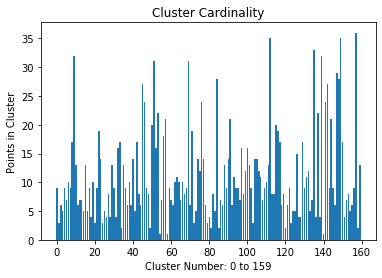

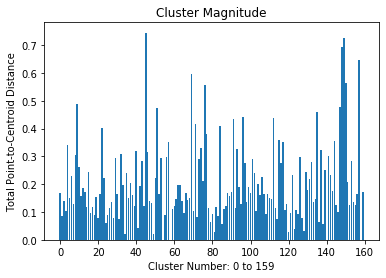

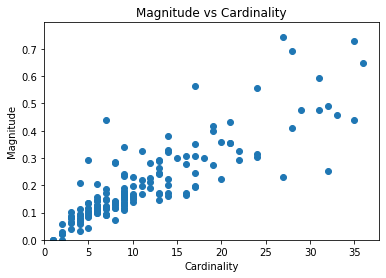

In [0]:
clusterQualityMetrics(choc_embed)

## Find Optimum Number of Clusters

k-means converged for 5 clusters after 22 iterations!
k-means converged for 15 clusters after 72 iterations!
k-means converged for 25 clusters after 28 iterations!
k-means converged for 35 clusters after 38 iterations!
k-means converged for 45 clusters after 22 iterations!
k-means converged for 55 clusters after 27 iterations!
k-means converged for 65 clusters after 42 iterations!
k-means converged for 75 clusters after 25 iterations!
k-means converged for 85 clusters after 23 iterations!
k-means converged for 95 clusters after 16 iterations!
k-means converged for 105 clusters after 19 iterations!
k-means converged for 115 clusters after 20 iterations!
k-means converged for 125 clusters after 16 iterations!
k-means converged for 135 clusters after 18 iterations!
k-means converged for 145 clusters after 14 iterations!
k-means converged for 155 clusters after 28 iterations!
k-means converged for 165 clusters after 14 iterations!
k-means converged for 175 clusters after 18 iterations!
k-m

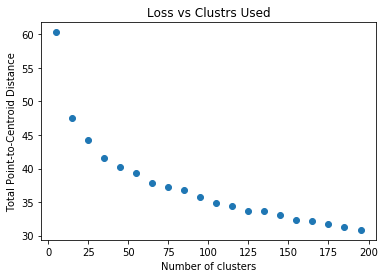

In [0]:
# Plot loss vs number of clusters
def lossvsClusters(kmin, kmax, kstep, choc_data):
  kmax+=1
  kRange = range(kmin, kmax, kstep)
  loss = np.zeros(len(kRange))
  lossCtr = 0
  for kk in kRange:
    [choc_data, centroids] = kmeans(choc_data, kk, feature_cols, 0)
    loss[lossCtr] = np.sum(choc_data['pt2centroid'])
    lossCtr += 1
  plt.scatter(kRange, loss)
  plt.title('Loss vs Clustrs Used')
  plt.xlabel('Number of clusters')
  plt.ylabel('Total Point-to-Centroid Distance')


kmin = 5 #@param
kmax = 200 #@param
kstep = 10 #@param
lossvsClusters(kmin, kmax, kstep, choc_embed)

##Summary
The codelab demonstrates these characteristics of a supervised similarity measure, described on the page Supervised Similarity Measure in the table "Comparison of Manual and Supervised Measures":

**Eliminates redundant information in correlated features**. As discussed in this section, the DNN eliminates redundant information. However, to prove this characteristic, you'd need to train the DNN on adequate data and then compare with the results of a manual similarity measure.

**Does not provides insight into calculated similarities**. Because you do not know what the embeddings represent, you have no insight into the clustering result.

**Suitable for large datasets with complex features**. Our dataset was too small to adequately train the DNN, demonstrating that DNNs need large datasets to train. The advantage is that you do not need to understand the input data. Since large datasets are not easy to understand, these two characteristics go hand-in-hand.
Not suitable for small datasets. A small dataset does not have enough information to train the DNN.